Preparing data...


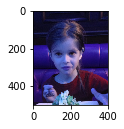

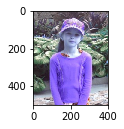

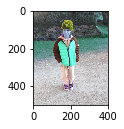

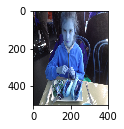

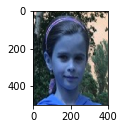

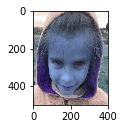

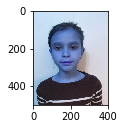

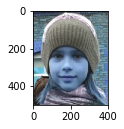

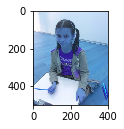

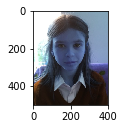

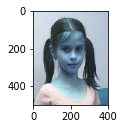

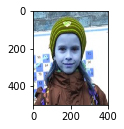

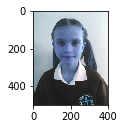

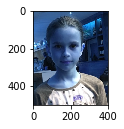

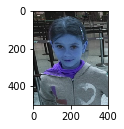

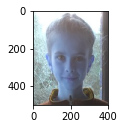

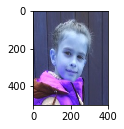

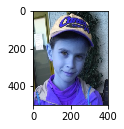

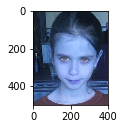

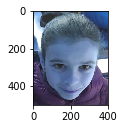

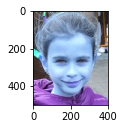

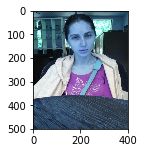

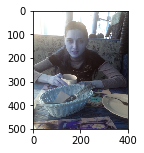

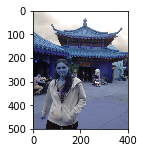

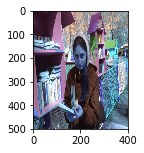

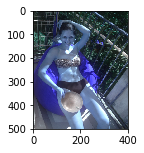

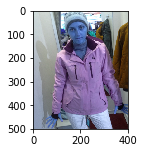

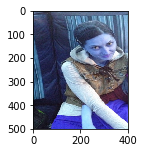

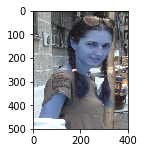

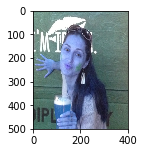

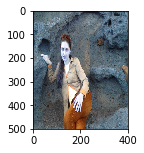

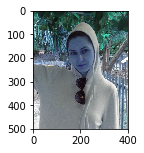

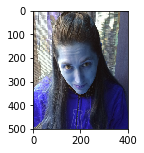

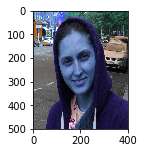

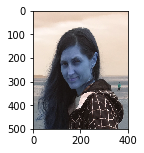

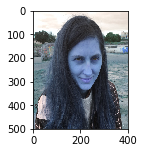

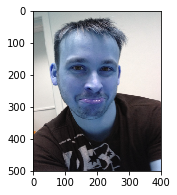

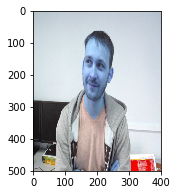

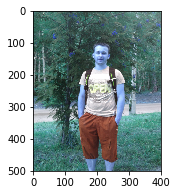

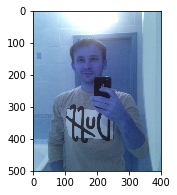

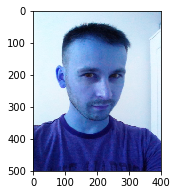

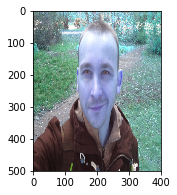

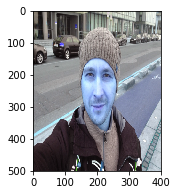

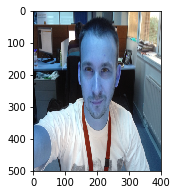

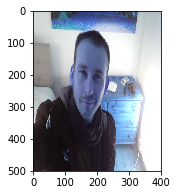

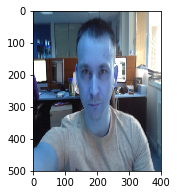

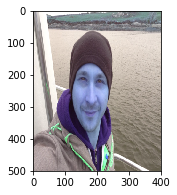

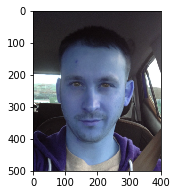

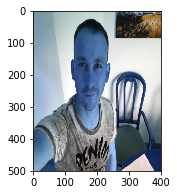

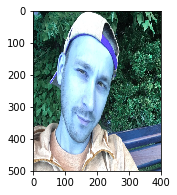

Data prepared
Total faces:  36
Total labels:  36
Predicting images...
Prediction complete


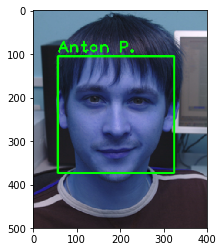

In [9]:
# coding: utf-8
import cv2
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

subjects = ["", "", "Elvis Presley", "Diana P.",  "Yulia K.", "Anton P."]

def detect_face(img, o_path=None):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #load OpenCV face detector, I am using LBP which is fast
    #there is also a more accurate but slow Haar classifier
    face_cascade = cv2.CascadeClassifier('opencv-files/lbpcascade_frontalface.xml')

    #let's detect multiscale (some images may be closer to camera than others) images
    #result is a list of faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5);

    #if no faces are detected then return original img
    if (len(faces) == 0):
        return None, None

    #under the assumption that there will be only one face,
    #extract the face area

    if len(faces) > 1:
        print("found more then 1 face", o_path)

    (x, y, w, h) = faces[0]

    #return only the face part of the image
    return gray[y:y+w, x:x+h], faces[0]

def prepare_training_data(data_folder_path):

    #------STEP-1--------
    #get the directories (one directory for each subject) in data folder
    dirs = os.listdir(data_folder_path)

    #list to hold all subject faces
    faces = []
    #list to hold labels for all subjects
    labels = []

    #let's go through each directory and read images within it
    for dir_name in dirs:

        #our subject directories start with letter 's' so
        #ignore any non-relevant directories if any
        if not dir_name.startswith("s"):
            continue;

        #------STEP-2--------
        #extract label number of subject from dir_name
        #format of dir name = slabel
        #, so removing letter 's' from dir_name will give us label
        label = int(dir_name.replace("s", ""))

        #build path of directory containin images for current subject subject
        #sample subject_dir_path = "training-data/s1"
        subject_dir_path = data_folder_path + "/" + dir_name

        #get the images names that are inside the given subject directory
        subject_images_names = os.listdir(subject_dir_path)

        #------STEP-3--------
        #go through each image name, read image,
        #detect face and add face to list of faces
        
        i = 0
        for image_name in subject_images_names:

            #ignore system files like .DS_Store
            if image_name.startswith("."):
                continue;

            #build image path
            #sample image path = training-data/s1/1.pgm
            image_path = subject_dir_path + "/" + image_name

            #read image
            image = cv2.imread(image_path)

            #display an image window to show the image
            
            
            plt.figure(figsize=(20,10))
            columns = 5
            
            i = i + 1
            plt.subplot(len(subject_images_names) / columns + 1, columns, i + 1)
            plt.imshow(cv2.resize(image, (400, 500)))
            
            plt.show() 
            #cv2.imshow("Training on image...", cv2.resize(image, (400, 500)))
            # cv2.waitKey(100)

            #detect face
            face, rect = detect_face(image, image_path)

            #------STEP-4--------
            #for the purpose of this tutorial
            #we will ignore faces that are not detected
            if face is not None:
                #add face to list of faces
                faces.append(face)
                #add label for this face
                labels.append(label)

    return faces, labels


print("Preparing data...")
faces, labels = prepare_training_data("training-data")
print("Data prepared")

#print total faces and labels
print("Total faces: ", len(faces))
print("Total labels: ", len(labels))


#create our LBPH face recognizer
face_recognizer = cv2.face.LBPHFaceRecognizer_create()

#train our face recognizer of our training faces
face_recognizer.train(faces, np.array(labels))

def draw_rectangle(img, rect):
    (x, y, w, h) = rect
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

def draw_text(img, text, x, y):
    cv2.putText(img, text, (x, y), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 2)

def predict(test_img, o_path=None):
    #make a copy of the image as we don't want to chang original image
    img = test_img.copy()
    #detect face from the image
    face, rect = detect_face(img, o_path)

    #predict the image using our face recognizer
    label, confidence = face_recognizer.predict(face)
    #get name of respective label returned by face recognizer
    label_text = subjects[label]

    #draw a rectangle around face detected
    draw_rectangle(img, rect)
    #draw name of predicted person
    draw_text(img, label_text, rect[0], rect[1]-5)

    return img

print("Predicting images...")

test_img10 = cv2.imread("test-data/me_300.jpg")

#perform a prediction
predicted_img10 = predict(test_img10, "test_img10")
print("Prediction complete")

plt.imshow(cv2.resize(predicted_img10, (400, 500)))
plt.show()

